### EDA of House Price Prediction data
- [Document contains the complete flow](https://docs.google.com/document/d/14CjFWvGZS9hyNudNY46WK1OasQNBuOrobnsO2wGEXR8/edit?usp=sharing)

In [41]:
# Paths
PWD = "/home/hanchau/proj/ds/spinny/"
TRAIN_DATA = "data/house_train.csv"
TEST_DATA = "data/house_test.csv"
import os; os.chdir(PWD)

# Dependencies
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
from copy import copy

# Helpers & Utils
class PreProcess:
    """
        PreProcess: Library for pre processing
    """

    def load_data(path):
        """
        Loading data
        """
        ret = pd.read_csv(path)
        print(f"Loaded file: {path}")
        return ret


    def drop_un(df, cols):
        """
        Dropping unnecessary features
        """
        try: 
            ret = df.drop(cols, axis=1)
            print(f"Dropped Columns: {cols}")
            return ret
        except: 
            ret = df.drop(cols[-1], axis=1)
            print(f"Dropped Columns: {cols[-1]}")
            return ret


    def check_nan(df, col):
        """
        Check nan values for each class of a feature
        """
        ret = df[col].isnull().values.sum()
        print(f"Checking nan in: {col}")
        return ret


    def count_nan(df, cols):
        """
        Check nan values for a feature
        """
        ret = df[cols].isna().sum().to_frame(name='counts')

        print(f"Counted the nan values in: {cols}")
        return ret


    def make_cat(df, col, bins, labels):
        """
        Make custom groups/classes
        """
        df[col] = pd.cut(df[col], bins=bins, labels=labels)
        print(f"Made custom classes: {labels}")


    def check_agg(df, col):
        """
        Check class level aggregates for a column
        """
        ret = pd.DataFrame(df[col].value_counts())
        print(f"Checking counts in: {col}")
        return ret


    def check_agg_all(df):
        """
        Check class level aggregates for all columns
        """
        ret = []
        for col in df.columns:
            ret.append(pd.DataFrame(df[col].value_counts()))
        print(f"Checking class aggregates of all Columns:", end="\n")
        return ret


    def fill_na(df, cols, kind='mode'):
        """
        Various strategies for filling nan
            type: mean, median, mode, nan_class
        """

        def fill_mode():
            """
            Modes can be multiple, pick the first one
            """
            for col in cols:
                df[col].fillna(df[col].mode()[0], inplace=True)

        def fill_median():
            for col in cols:
                df[col].fillna(df[col].median(), inplace=True)

        def fill_mean():
            for col in cols:
                df[col].fillna(df[col].mean(), inplace=True)

        def fill_nan_class():
            for col in cols:
                df[col].fillna("NAN_CLASS", inplace=True)

        if kind=='mode':
            fill_mode()
        elif kind=='mean':
            fill_mean()
        elif kind=='median':
            fill_median()
        elif kind=='nan_class':
            fill_nan_class()

        print(f"Fill NAN strategy: {kind}")


    def info(df):
        """
        Get the basic info of data frame
        """
        shape = df.shape
        print(f"All features and Null Counts:", end="\n") 
        return df.info()
        print("\n\n\n")
    

    def get_nan(df):
        """
        Get the columns with nan to handle
        """
        ret = df.columns[df.isna().any()].tolist()
        print(f"#NAN columns: {len(ret)}, NAN columns: {ret}", end="\n\n") 
        return ret


    def describe(df):
        """
        Comprehensive aggregates description of all features
        """
        print(f"Comprehensive aggregate description", end="\n")
        return df.describe(include='all').T


    def describe_missing(df):
        """
        Comprehensive aggregates description of the features with nan values
        """
        print(f"Aggregate description for Missing", end="\n")
        ret = df.describe(include='all').T
        ret = ret[ret['count'] != 1168]
        print(ret)
        return ret

class EDA:
    """
    EDA: Library for ploting and analysing after Pre Processing
    """
    
    def set_palette():
        """
        Set the colors that will be used in the EDA plots
        """
        custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
        customPalette = sns.set_palette(sns.color_palette(custom_colors))
        sns.palplot(sns.color_palette(custom_colors),size=1)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        return custom_colors


    def get_palette(colors, color):
        """
        Get a gradient type color palette
        """
        palette = sns.dark_palette(colors[color], reverse=True)
        sns.palplot(sns.color_palette(palette),size=1)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        return palette


    def plot_grad(df, col):
        """
        Simple plot of x vs y
        """ 
        print(f"Gradient plot of: {col}")
        ret = df.sort_values(by=col, ascending=False).style.background_gradient(cmap='Reds')
        return ret

    def plot_dist(df, col):
        """
        Simple plot of distribution of samples across col values
        """
        print(f"Ploting columns: {col}", end="\n")
        sns.distplot(df[col])

 
    def plot_dist_all(df, cols = [], kind = 'box', target = '', sections = ''):
        """
        Simple plots of distribution of samples across all columns
            df:  data
            cols:  cols to consider
            kind:  which kind of plot
            target:  values on y axes
            sections:  no. of columns of subplots
        TODO:
            Add feature of axis - ax=axes[i//sections, i%sections], 
        """
        print(f"Plotting all features distribution.\nIt may take a while..", end="\n\n")
        skipped_cols = []
        if cols is None: cols = df.columns 
        
        if not sections: 
            pass
        else: 
            fig, axes = plt.subplots(len(cols)//sections + 1, sections, figsize=(30, 50))
        
        for i, col in enumerate(cols):
            try: 
                if kind == 'box':
                    sns.boxplot(data=df, x=col, y=target, ax=axes[i//sections, i%sections])
                elif kind == 'hist':
                    sns.displot(data=df, x=col, kind='hist')
                elif kind == 'kde':
                    sns.displot(data=df, x=col, kind='kde')
                elif kind == 'ecdf':
                    sns.displot(data=df, x=col, kind='ecdf', ax=axes[i//sections, i%sections])
                elif kind == 'bar':
                    sns.barplot(ax=axes[i//sections, i%sections], data=df, x=col, y=target)
            except Exception as e: 
                print(e)
                skipped_cols.append(col)
        return skipped_cols


    def plot_cont(df, col):
        """
        Plot contingency matrix for a column
        """
        pass


    def plot_cont_all(df, cols = []):
        """
        Plot contingency matrix for all columns
        """
        pass



# Data loading
data = PreProcess.load_data(TRAIN_DATA)
t_data = PreProcess.load_data(TEST_DATA)

Loaded file: data/house_train.csv
Loaded file: data/house_test.csv


### STUDY FEATURES

- There are 81 Features with 18 features having Missing Values
- The #samples we have here are - 1168

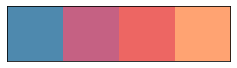

In [5]:
# Set the working palette
colors = EDA.set_palette()

In [6]:
# PreProcess.info(data)
desc = PreProcess.describe(data)
desc

Comprehensive aggregate description


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1168.0,NaN,NaN,NaN,583.5,337.316864,0.0,291.75,583.5,875.25,1167.0
MSSubClass,1168.0,NaN,NaN,NaN,57.251712,42.189213,20.0,20.0,50.0,70.0,190.0
MSZoning,1168,5,RL,912,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,982.0,NaN,NaN,NaN,70.092668,24.737533,21.0,59.0,69.0,80.0,313.0
LotArea,1168.0,NaN,NaN,NaN,10571.564212,10543.102521,1300.0,7487.25,9355.0,11530.0,215245.0
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1168.0,NaN,NaN,NaN,6.357877,2.679448,1.0,5.0,6.0,8.0,12.0
YrSold,1168.0,NaN,NaN,NaN,2007.797945,1.328069,2006.0,2007.0,2008.0,2009.0,2010.0
SaleType,1168,9,WD,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1168,6,Normal,956,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- There are two types of features --> Categorical and Continueous
- Featres with their gropus are pasted [here](https://docs.google.com/document/d/14CjFWvGZS9hyNudNY46WK1OasQNBuOrobnsO2wGEXR8/edit?usp=sharing)

In [7]:
# Categorical or Continueous
agg = PreProcess.check_agg_all(data)
print(agg[0])

Checking class aggregates of all Columns:
      Id
0      1
767    1
783    1
782    1
781    1
...   ..
388    1
387    1
386    1
385    1
1167   1

[1168 rows x 1 columns]


In [8]:
# Missing Values
nan_cols = PreProcess.get_nan(data)
missing = PreProcess.count_nan(data, nan_cols)
EDA.plot_grad(missing, col='counts')

#NAN columns: 18, NAN columns: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Counted the nan values in: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Gradient plot of: counts


,counts
PoolQC,1165
MiscFeature,1128
Alley,1094
Fence,946
FireplaceQu,554
LotFrontage,186
GarageType,65
GarageYrBlt,65
GarageFinish,65
GarageQual,65


Comprehensive aggregate description
Aggregate description for Missing
               count unique     top  freq        mean         std     min  \
LotFrontage    982.0    NaN     NaN   NaN   70.092668   24.737533    21.0   
Alley             74      2    Grvl    39         NaN         NaN     NaN   
MasVnrType      1161      4    None   696         NaN         NaN     NaN   
MasVnrArea    1161.0    NaN     NaN   NaN  104.009475  181.134311     0.0   
BsmtQual        1135      4      TA   525         NaN         NaN     NaN   
BsmtCond        1135      4      TA  1046         NaN         NaN     NaN   
BsmtExposure    1134      4      No   761         NaN         NaN     NaN   
BsmtFinType1    1135      6     Unf   339         NaN         NaN     NaN   
BsmtFinType2    1135      6     Unf  1005         NaN         NaN     NaN   
FireplaceQu      614      5      Gd   312         NaN         NaN     NaN   
GarageType      1103      6  Attchd   690         NaN         NaN     NaN   
Garage

[]

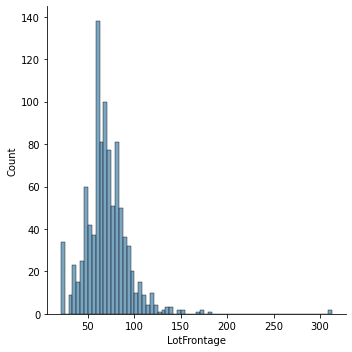

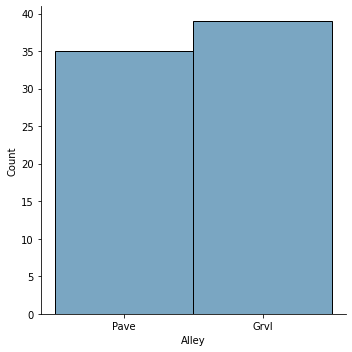

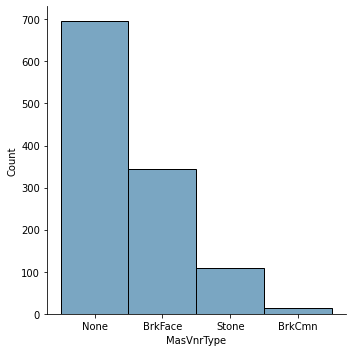

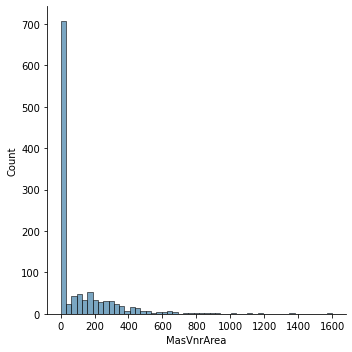

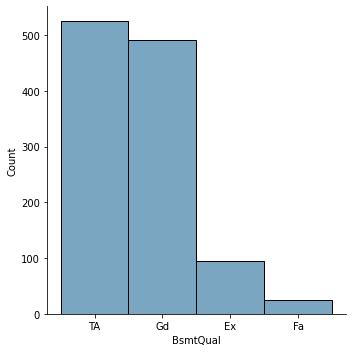

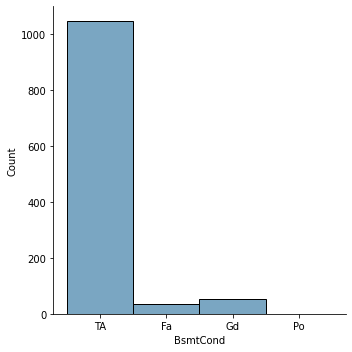

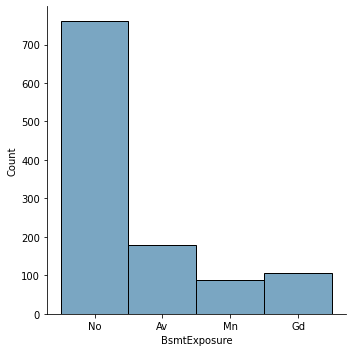

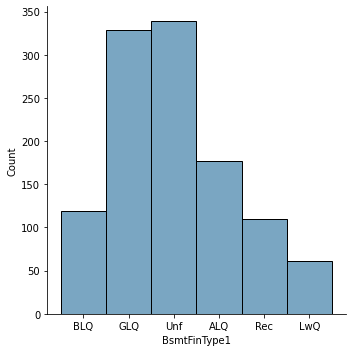

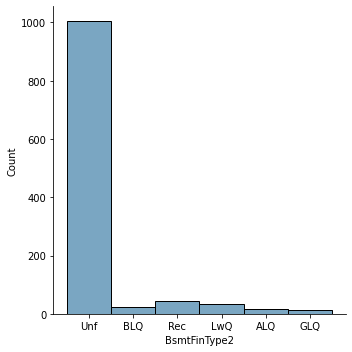

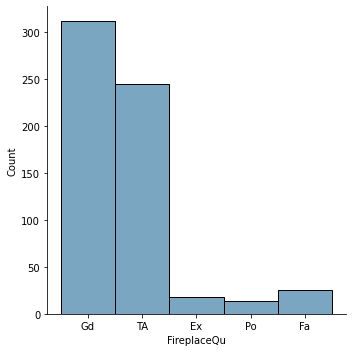

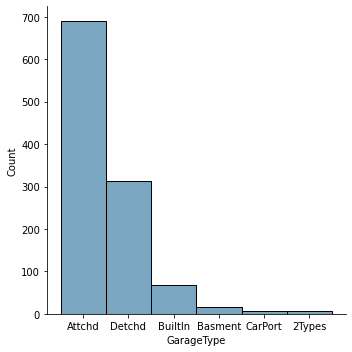

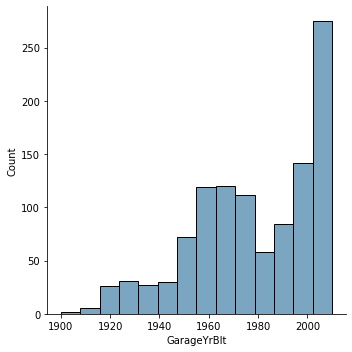

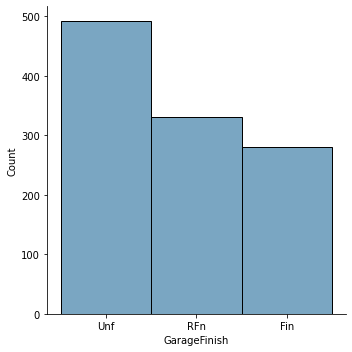

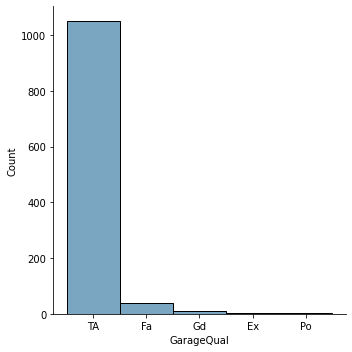

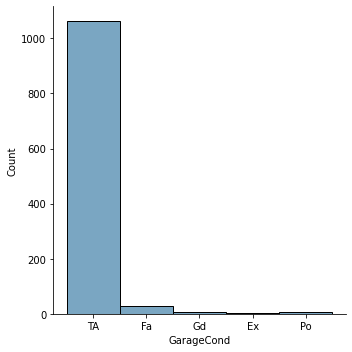

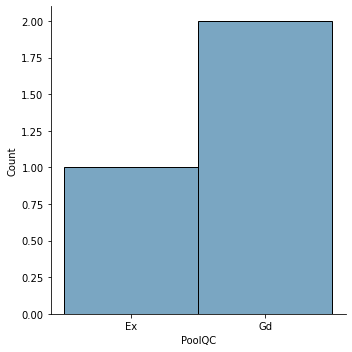

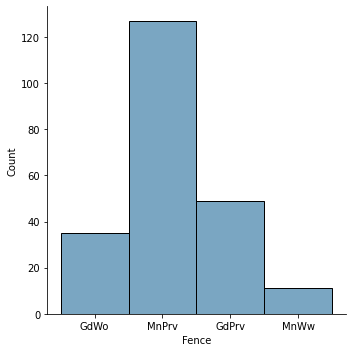

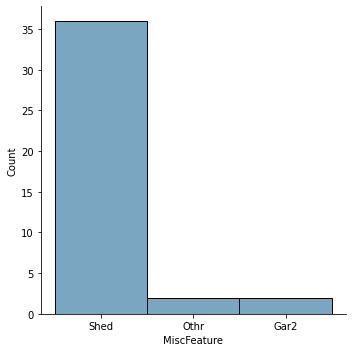

In [9]:
# Figuering out "Filling missing values" strategy

desc = PreProcess.describe(data)
desc = PreProcess.describe_missing(data)


# Distribution - hist, kde, ecdf
EDA.plot_dist_all(data, cols = desc.T.columns, kind = 'hist', target = 'SalePrice')


#### Missing Vlaues
Few of the features have missing values, implying improper data

    1. GarageYrBlt   - nan are missing values - [Mode]
    2. LotFrontage    - skewed normal distribution - [Median]
    3. MasVnrArea     - nan are missing values, 0 are more than half - [Mode]

Few of the missing values in features are in actuall a separate class   

    1. PoolQC         - nan means the pool is absent in the property - [NAN class]
    2. Alley          - nan means no alley access - [NAN class]
    3. MasVnrType     - nan means no masonry veneeer types - [NAN class]
    4. BsmtQual       - nan means no basement - [NAN class]
    5. BsmtCond       - nan means no basement - [NAN class]
    6.  BsmtExposure   - nan means no basement - [NAN class]
    7.  BsmtFinType1   - nan means no basement - [NAN class]
    8.  BsmtFinType2  - nan means no basement - [NAN class]
    9.  FireplaceQu   - nan means no fireplace - [NAN class]
    10. GarageType    - nan means no fireplace - [NAN class]
    11. GarageFinish  - nan means no garage - [NAN class]
    12. GarageQual    - nan means no garage - [NAN class]
    13. GarageCond    - nan means no garage - [NAN class]
    14. Fence         - nan means no fence - [NAN class]
    15. MiscFeature   - nan means no misc feature - [NAN class]

Fill NAN strategy: mode
Fill NAN strategy: median
Fill NAN strategy: nan_class
Plotting all features distribution.
It may take a while..

Comprehensive aggregate description


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1168.0,NaN,NaN,NaN,583.5,337.316864,0.0,291.75,583.5,875.25,1167.0
MSSubClass,1168.0,NaN,NaN,NaN,57.251712,42.189213,20.0,20.0,50.0,70.0,190.0
MSZoning,1168,5,RL,912,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1168.0,NaN,NaN,NaN,69.918664,22.684175,21.0,60.0,69.0,79.0,313.0
LotArea,1168.0,NaN,NaN,NaN,10571.564212,10543.102521,1300.0,7487.25,9355.0,11530.0,215245.0
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1168.0,NaN,NaN,NaN,6.357877,2.679448,1.0,5.0,6.0,8.0,12.0
YrSold,1168.0,NaN,NaN,NaN,2007.797945,1.328069,2006.0,2007.0,2008.0,2009.0,2010.0
SaleType,1168,9,WD,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1168,6,Normal,956,NaN,NaN,NaN,NaN,NaN,NaN,NaN


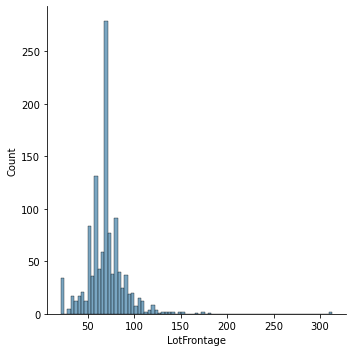

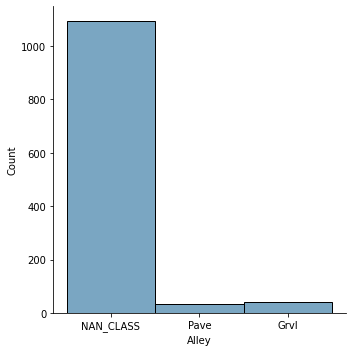

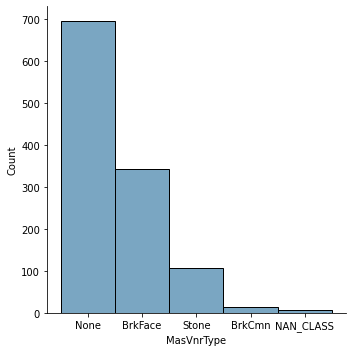

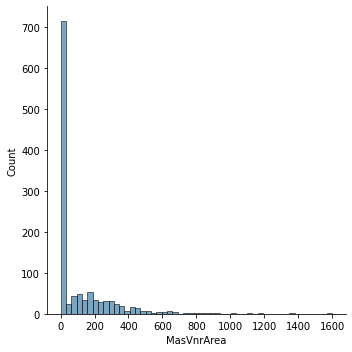

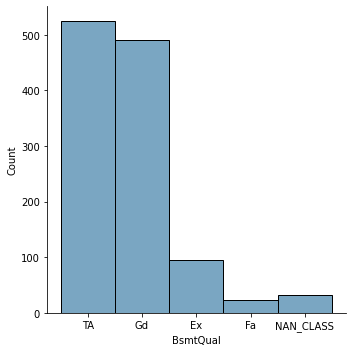

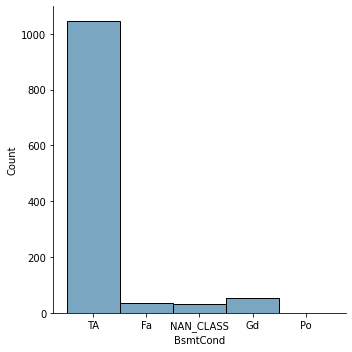

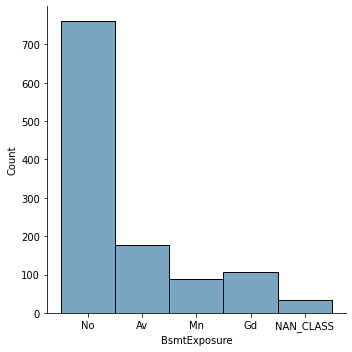

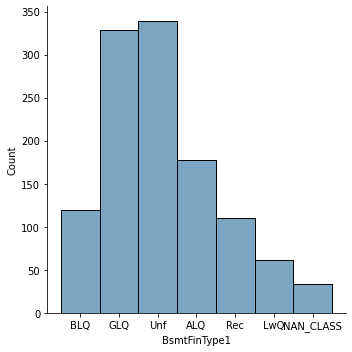

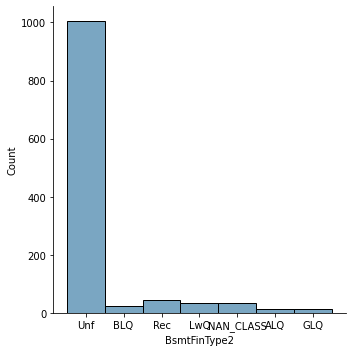

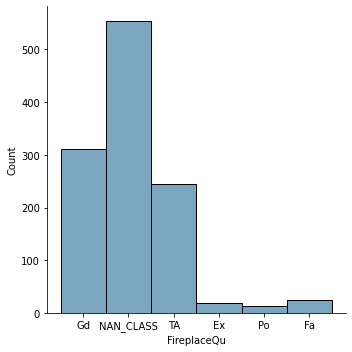

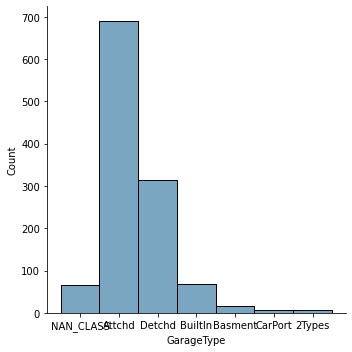

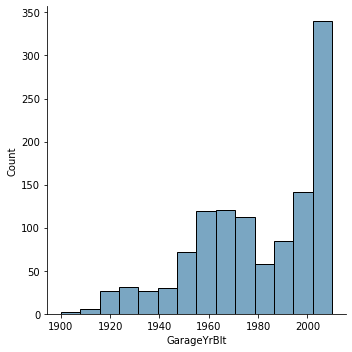

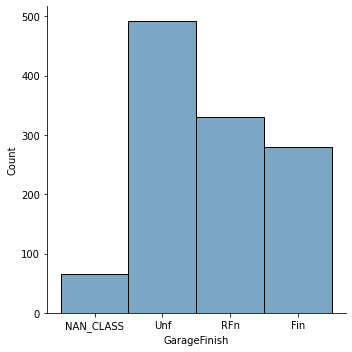

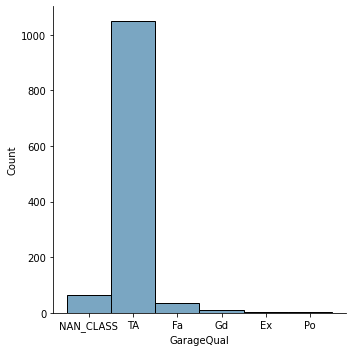

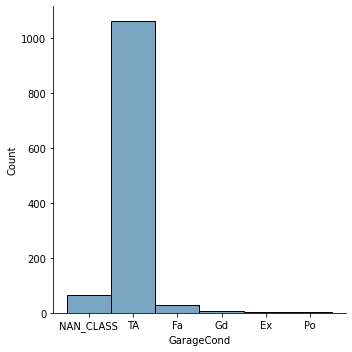

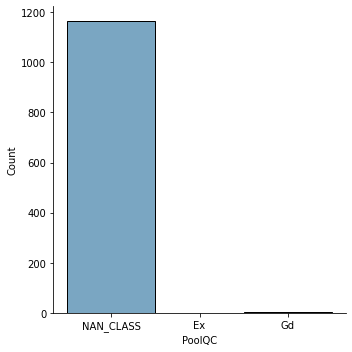

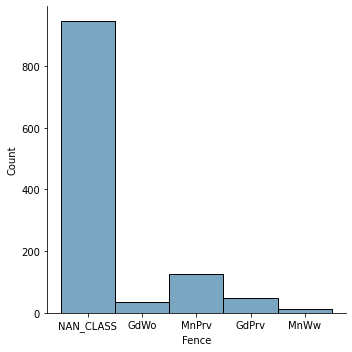

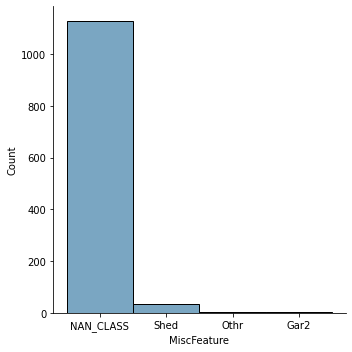

In [43]:
# Filling Missing Values

feat_mode = ['GarageYrBlt', 'MasVnrArea']
feat_median = ['LotFrontage']
feat_na_class = list(set(nan_cols) - set(feat_mode + feat_median))

data_fld_na = copy(data)
PreProcess.fill_na(data_fld_na, feat_mode, kind='mode')
PreProcess.fill_na(data_fld_na, feat_median, kind='median')
PreProcess.fill_na(data_fld_na, feat_na_class, kind='nan_class')

# Plots after filling nan
EDA.plot_dist_all(data_fld_na, cols = desc.T.columns, kind = 'hist', target = 'SalePrice')

# New summary
PreProcess.describe(data_fld_na)

0    2005.0
Name: GarageYrBlt, dtype: float64

### ARCHIVES

Ploting columns: SalePrice


AttributeError: type object 'EDA' has no attribute 'plot_all_dist'

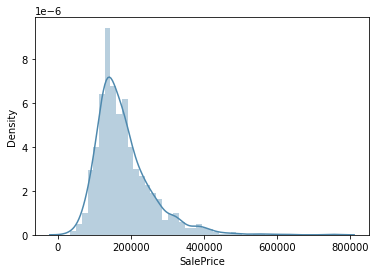

In [11]:


# Before Cleaning Plots
EDA.plot_dist(data, "SalePrice")
EDA.plot_all_dist(data)

    # def plot_all_bar(df, target=""):
    #     print(f"Plotting all features.\nIt may take a while..", end="\n\n")
    #     plt.figure(figsize=(20, 10))
    #     plot_id = 321
    #     skipped_cols = []
    #     def _plot_one(df, col):
    #         try:
    #             plt.subplot(plot_id)
    #             sns.barplot(x = col, y = target, data = df)
    #         except: skipped_cols.append(col)

    #     for col in df.columns:
    #         _plot_one(df, col)
    #         plot_id += 1
        
    #     print(f"Few columns faced exception: {skipped_cols}")